In [1]:
# init pyimage to get access to jar files
import imagej
ij = imagej.init('C:/programs/fiji-win64/Fiji.app/')

# load some image data
from skimage import io
sk_img = io.imread('https://samples.fiji.sc/blobs.png')

# init clijpy to get access to the GPU
from jnius import autoclass
CLIJx = autoclass('net.haesleinhuepf.clijx.CLIJx')
clijx = CLIJx.getInstance();

Added 425 JARs to the Java classpath.


In [2]:
def showImages(img1, img2):
    vals = np.linspace(0,1,256)
    np.random.shuffle(vals)
    
    # show the input and the result image
    from matplotlib import pyplot as plt
    cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
    plt.subplot(121)
    plt.imshow(img1)
    plt.subplot(122)
    plt.imshow(img2, cmap=cmap, vmin=0, vmax=65)
    plt.show()

In [3]:

# convert and array to an ImageJ2 img:
import numpy as np
np_arr = np.array(sk_img)
ij_img = ij.py.to_java(np_arr)

# push the image to the GPU
input8 = clijx.push(ij_img)
input = clijx.create(input8.getDimensions())
clijx.copy(input8, input)

True

In [4]:
# reserve memory for output, same size and type as input
blurred = clijx.create(input);
thresholded = clijx.create(input);
labelled = clijx.create(input);
labelled_without_edges = clijx.create(input);

In [5]:
# blur, threshold and label the image
clijx.blur(input, blurred, 5, 5, 0);
clijx.automatic_threshold(blurred, thresholded, "Otsu");
clijx.connected_components_labeling(thresholded, labelled);
clijx.exclude_labels_on_edges(labelled, labelled_without_edges);

First conversion
1649
Second conversion
67
Third conversion, this time with custom code
43


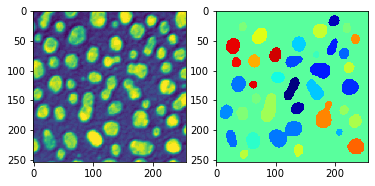

In [6]:
# pull image back from GPU
ij_img_result = clijx.pull(labelled_without_edges);
# convert to numpy/python
import time
def getTime():
    return int(round(time.time() * 1000))

# np_arr_result = ij.py.rai_to_numpy(ij_img_result);
def my_rai_to_numpy(rai):
    result = ij.py.new_numpy_image(rai)
    CopyRAI = autoclass('net.imagej.ops.copy.CopyRAI');
    ij.py._ij.op().run(CopyRAI, ij.py.to_java(result), rai)
    return result

print("First conversion");
millis = getTime();
np_arr_result = ij.py.rai_to_numpy(ij_img_result);
print (getTime() - millis)

print("Second conversion");
millis = getTime();
np_arr_result = ij.py.rai_to_numpy(ij_img_result);
print (getTime() - millis)

print("Third conversion, this time with custom code");
millis = getTime();
np_arr_result = my_rai_to_numpy(ij_img_result);
print (getTime() - millis)

# show the input and the result image
showImages(np_arr, np_arr_result);

In [8]:
# clean up
input.close();
blurred.close();
thresholded.close();
labelled.close();
labelled_without_edges.close();